## Libraries

In [1]:
import sys
sys.path.append('./venv/lib/python3.6/site-packages')

In [2]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image

In [3]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms as vtransforms
from torchvision import utils as vutils
from torchvision import datasets

In [4]:
from gans.utils.data import CartoonSet
from gans.utils.layers import *
from gans.utils.functions import *
from gans.models import *
from gans.trainer import *

## Random seed

In [5]:
# Set random seem for reproducibility
# manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  2682


## Inputs

In [6]:
# Dataset
data_root = './datasets'
# data_name = 'CartoonSet'
data_name = 'FashionMNIST'
# data_name = 'MNIST'

batch_size = 200
sample_size = 50
nrow = 5

num_epochs = 50

num_workers = 8


# Output dir
output_root = './output/condDCGAN'
# overwrite real sample output
overwrite_real = False

noize_dim = 100

# Optimization parameters
lr = 0.001
beta1 = 0.5

## Device

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print('using device: ', device)

using device:  cuda:1


## Dataset

In [8]:
img_size = 28
in_channels = 1

if data_name == 'CartoonSet':
    img_size = 75
    dataset = CartoonSet(root=os.path.join(data_root, data_name), 
                         transform=vtransforms.Compose([
                             vtransforms.CenterCrop(size=400),
                             vtransforms.Resize(size=img_size), 
                             vtransforms.ToTensor(),
                             vtransforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                         ]))
    
elif data_name == 'MNIST':
    dataset = datasets.MNIST(root=os.path.join(data_root, data_name), 
                             download=True,
                             transform=vtransforms.Compose([
                                 vtransforms.ToTensor(),
                                 vtransforms.Normalize((0.5,), (0.5,)),
                         ]))
elif data_name == 'FashionMNIST':
    dataset = datasets.FashionMNIST(root=os.path.join(data_root, data_name), 
                                    download=True,
                                    transform=vtransforms.Compose([
                                        vtransforms.ToTensor(),
                                        vtransforms.Normalize((0.5,), (0.5,)),
                                    ]))
    
dtype = dataset[0][0].dtype
img_shape = dataset[0][0].shape

## Dataloader

In [9]:
dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         shuffle=True, 
                                         num_workers=num_workers)

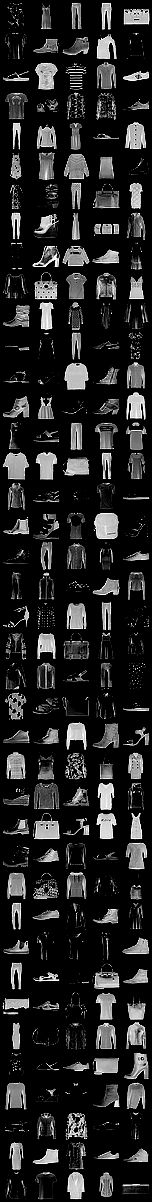

In [10]:
if not os.path.exists(os.path.join(output_root, data_name)):
    os.makedirs(os.path.join(output_root, data_name))

real_sample_path = os.path.join(output_root, data_name, 'real_samples.png')


real_batch = next(iter(dataloader))

vutils.save_image(real_batch[0], real_sample_path, 
                  normalize=True, range=(0,1), nrow=nrow)
Image(real_sample_path)

## Model

In [11]:
netG = CondDCGenerator(noize_dim=noize_dim)
print(netG)

CondDCGenerator(
  (encoder): OneHotEncoder()
  (model): Sequential(
    (0): Unflatten2d(img_shape=(110, 1, 1))
    (1): ConvTranspose2d(110, 256, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Tanh()
  )
)


In [12]:
netD = CondDCDiscriminator(reduced_dim=noize_dim)
print(netD)

CondDCDiscriminator(
  (encoder): OneHotEncoder()
  (model_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 100, kernel_size=(3, 3), stride=(1, 1))
    (9): Sigmoid()
    (10): Flatten()
  )
  (model_linear): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(i

## Training

In [13]:
y_fixed = torch.tensor([i//nrow for i in range(sample_size)], device=device)

In [14]:
trainer = CGANTrainer(generator=netG, discriminator=netD,
                     optimizer=optim.Adam, loss=nn.BCELoss(), y_fixed=y_fixed,
                     device=device, multi_gpu=False, output_path=os.path.join(output_root, data_name),
                     batch_size=batch_size, num_epochs=num_epochs, sample_size=sample_size)

In [15]:
trainer.train(dataloader=dataloader, nrow=nrow)

/home/shu/.local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[Epoch 0/50][Batch 0/300] Loss_D: 1.39 Loss_G: 0.74
[Epoch 0/50][Batch 60/300] Loss_D: 1.47 Loss_G: 0.58
[Epoch 0/50][Batch 120/300] Loss_D: 1.07 Loss_G: 2.47
[Epoch 0/50][Batch 180/300] Loss_D: 0.80 Loss_G: 3.33
[Epoch 0/50][Batch 240/300] Loss_D: 0.90 Loss_G: 1.79
Epoch 0 running time: 17.74
[Epoch 1/50][Batch 0/300] Loss_D: 0.63 Loss_G: 2.63
[Epoch 1/50][Batch 60/300] Loss_D: 0.60 Loss_G: 2.32
[Epoch 1/50][Batch 120/300] Loss_D: 0.61 Loss_G: 2.43
[Epoch 1/50][Batch 180/300] Loss_D: 0.83 Loss_G: 2.04
[Epoch 1/50][Batch 240/300] Loss_D: 0.74 Loss_G: 2.25
Epoch 1 running time: 17.34
[Epoch 2/50][Batch 0/300] Loss_D: 0.84 Loss_G: 3.48
[Epoch 2/50][Batch 60/300] Loss_D: 0.87 Loss_G: 1.81
[Epoch 2/50][Batch 120/300] Loss_D: 0.99 Loss_G: 1.53
[Epoch 2/50][Batch 180/300] Loss_D: 0.98 Loss_G: 1.51
[Epoch 2/50][Batch 240/300] Loss_D: 1.12 Loss_G: 1.55
Epoch 2 running time: 16.95
[Epoch 3/50][Batch 0/300] Loss_D: 0.81 Loss_G: 2.03
[Epoch 3/50][Batch 60/300] Loss_D: 1.13 Loss_G: 2.90
[Epoch 3/5

[Epoch 27/50][Batch 180/300] Loss_D: 0.43 Loss_G: 4.89
[Epoch 27/50][Batch 240/300] Loss_D: 0.41 Loss_G: 4.88
Epoch 27 running time: 17.74
[Epoch 28/50][Batch 0/300] Loss_D: 0.42 Loss_G: 3.61
[Epoch 28/50][Batch 60/300] Loss_D: 0.70 Loss_G: 4.87
[Epoch 28/50][Batch 120/300] Loss_D: 0.44 Loss_G: 4.06
[Epoch 28/50][Batch 180/300] Loss_D: 0.38 Loss_G: 3.22
[Epoch 28/50][Batch 240/300] Loss_D: 0.56 Loss_G: 4.94
Epoch 28 running time: 17.84
[Epoch 29/50][Batch 0/300] Loss_D: 0.80 Loss_G: 5.13
[Epoch 29/50][Batch 60/300] Loss_D: 0.32 Loss_G: 3.69
[Epoch 29/50][Batch 120/300] Loss_D: 0.33 Loss_G: 5.23
[Epoch 29/50][Batch 180/300] Loss_D: 0.44 Loss_G: 4.61
[Epoch 29/50][Batch 240/300] Loss_D: 0.34 Loss_G: 4.67
Epoch 29 running time: 17.98
[Epoch 30/50][Batch 0/300] Loss_D: 0.98 Loss_G: 5.32
[Epoch 30/50][Batch 60/300] Loss_D: 0.35 Loss_G: 4.80
[Epoch 30/50][Batch 120/300] Loss_D: 3.06 Loss_G: 8.10
[Epoch 30/50][Batch 180/300] Loss_D: 0.46 Loss_G: 4.09
[Epoch 30/50][Batch 240/300] Loss_D: 0.36 

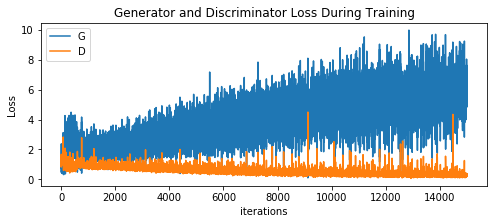

In [16]:
plt.figure(figsize=(8,3))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(trainer.g_losses,label="G")
plt.plot(trainer.d_losses,label="D")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(output_root, data_name, 'g_d_loss.png'))
plt.show()

In [17]:
gif_generator(image_dir=os.path.join(output_root, data_name), 
              name_pattern=r'fake_samples_epoch_[\d]+|.png')

In [18]:
image_sample_dir = 'samples'

fake_name = os.path.join(data_name, 'cDCGAN')

if not os.path.exists(os.path.join(image_sample_dir, fake_name)):
    os.makedirs(os.path.join(image_sample_dir, fake_name))

image_path = os.path.join(image_sample_dir, fake_name, 'img{:04}.png')


# switch to eval mode
netG.eval()

for i in range(2048):
    noise = torch.randn(1, noize_dim, 
                        dtype=dtype, device=device,
                        requires_grad=False)
    y = torch.randint(10, (1,), device=device, requires_grad=False)
    img = netG(noise, y)
    vutils.save_image(img, image_path.format(i), 
                      normalize=True, range=(0,1))